# Geoacoustic Parameter Estimation using Bayesian Optimization with a Gaussian Process Surrogate Model

William Jenkins | Scripps Institution of Oceanography | wjenkins@ucsd.edu

In [1]:
from pathlib import Path
import sys

from ax.modelbridge.generation_strategy import GenerationStrategy, GenerationStep
from ax.modelbridge.registry import Models
from ax.plot.slice import plot_slice
from ax.service.ax_client import AxClient
from ax.utils.notebook.plotting import render
import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import tqdm

sys.path.insert(0, '/Users/williamjenkins/Research/Code/TritonOA/')

from tritonoa.io import read_ssp
from tritonoa.kraken import KRAKENModelConfiguration, run_kraken
import tritonoa.plotting as plotting
from tritonoa.sp import ambiguity_function, normalize_pressure
from tritonoa.core import Top, Bottom, SoundSpeedProfile, Layer, Source, Receiver

## 1&nbsp;&nbsp;Simulate the Source

In this section, an acoustic pressure field is generated to simulate data that is recorded on an acoustic array.  These simulated data comprise the observed data to which replica data will be compared using the Bartlett processor.

### 1.1&nbsp;&nbsp;View TL given source depth over depth and range.

Before proceeding, let's look at what the transmission loss would look like for the given environment.

Text(0.5, 0.98, 'Source Depth = 54 m\nSource Freq = 148 Hz')

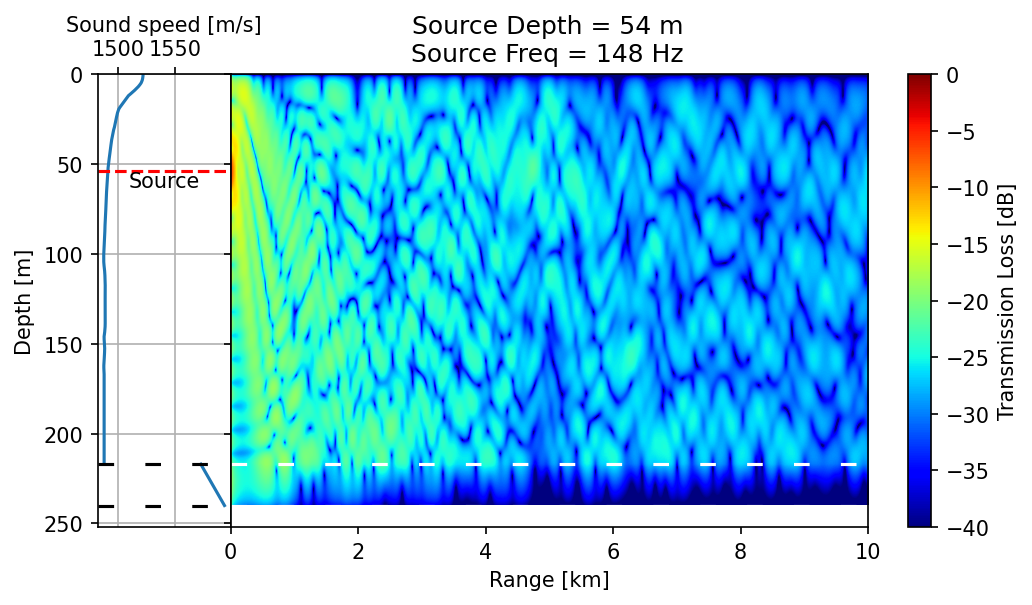

In [2]:
profile = "SWELLEX"
title = profile

fname = Path("/Users/williamjenkins/Research/Projects/BOGP/Data/ctds 2/i9606.prn")
z_data, c_data, _ = read_ssp(fname, 0, 3, header=None)
z_data = np.append(z_data, 217)
c_data = np.append(c_data, c_data[-1])

top = Top()

layerdata = [
    {
        "z": z_data,
        "c_p": c_data,
        "rho": 1
    },
    {
        "z": [217, 240],
        "c_p": [1572.37, 1593.02],
        "rho": 1.8,
        "a_p": 0.3
    },
    {
        "z": [240, 1040],
        "c_p": [1881, 3245.8],
        "rho": 2.1,
        "a_p": 0.09
    }
]

layers = [Layer(SoundSpeedProfile(**kwargs)) for kwargs in layerdata]

bottom = Bottom(opt="A", z=layers[-1].z_max+1, c_p=5200, rho=2.7, a_p=0.03)

source = Source(54)
zvec = np.arange(0, layers[1].z_max, 0.5)
dr = 0.5 * 1e-3
rvec = np.arange(0, 10 + dr, dr)
receiver = Receiver(zvec, rvec)

freq = 148
clow = 0
chigh = 1600

kmodel = KRAKENModelConfiguration(
    title,
    freq,
    layers,
    top,
    bottom,
    source,
    receiver,
    clow=clow,
    chigh=chigh,
    tmpdir="tmp"
)

model = "KRAKENC"
kmodel.run(fldflag=True, model=model)
p_rec = kmodel.modes.p
p_rec_norm = normalize_pressure(kmodel.modes.p, log=True)


fig, axs = plt.subplots(1, 2, sharey=True, gridspec_kw={"width_ratios": [1, 6], "wspace": 0}, figsize=(8, 4), dpi=150)

z = np.array([])
c = np.array([])
b = np.array([])
for layer in layers[:-1]:
    z = np.concatenate((z, layer.ssp.z))
    c = np.concatenate((c, layer.ssp.c_p))
    b = np.concatenate((b, [layer.z_max]))

ax = plotting.plot_SSP(
    z,
    c,
    boundaries=b,
    xlabel="Sound speed [m/s]",
    ylabel="Depth [m]",
    ax=axs[0]
)
ax.axhline(kmodel.source.z, c='r', linestyle='--')
ax.text(np.mean(ax.get_xlim()), kmodel.source.z.item(), f"Source", ha="center", va="top")

ax = plotting.plot_TL_2d(
    p_rec_norm,
    z=kmodel.receiver.z,
    r=np.concatenate((np.array([0]), kmodel.receiver.r)),
    boundaries=b,
    xlabel="Range [km]",
    clabel="Transmission Loss [dB]",
    vmin=-40,
    ax=axs[1]
)
fig.suptitle(f"Source Depth = {kmodel.source.z.item()} m\nSource Freq = {freq} Hz")
# fig.savefig("../../Reports/Figures/TL_SWELLEX_148Hz_54m_8km.png", dpi=300, facecolor="white", bbox_inches="tight")

### 1.2&nbsp;&nbsp;Set the parameters of the source.

Now that we have an understanding of what the acoustic propagation looks like for this environment, let's proceed with simulating the source.  First we will set source location and geoacoustic parameters of the environment.

In [3]:
depth_true = 54
range_true = 4.4

# ======================================================================
# ---------------------- Miscellaneous Parameters ----------------------
fixedparams = dict()
fixedparams["title"] = "SWELLEX96"
fixedparams["tmpdir"] = "tmp"
fixedparams["model"] = "KRAKENC"

# --------------------------- Top Parameters ---------------------------
# None to configure.

# -------------------------- Layer Parameters --------------------------
fixedparams["layerdata"] = [
    {
        "z": z_data,
        "c_p": c_data,
        "rho": 1
    },
    {
        "z": [217, 240],
        "c_p": [1572.37, 1593.02],
        "rho": 1.8,
        "a_p": 0.3
    },
    {
        "z": [240, 1040],
        "c_p": [1881, 3245.8],
        "rho": 2.1,
        "a_p": 0.09
    }
]

# ------------------------- Bottom Parameters --------------------------
# Note: By default, bottom depth is pulled from layer data
fixedparams["bot_opt"] = "A"
fixedparams["bot_c_p"] = 5200
fixedparams["bot_rho"] = 2.7
fixedparams["bot_a_p"] = 0.03

# ------------------------- Source Parameters --------------------------
fixedparams["src_z"] = depth_true

# ------------------------ Receiver Parameters ------------------------
fixedparams["rec_z"] = np.linspace(94.125, 212.25, 64)
fixedparams["rec_r"] = range_true


# ------------------------ Freq/Mode Parameters ------------------------
fixedparams["freq"] = freq
fixedparams["clow"] = 0
fixedparams["chigh"] = 1600

### 1.3&nbsp;&nbsp;Calculate received pressure field.

Using the environmental and localization parameters set above, we compute the received pressure field at the receiver array for the simulated source.

Text(0.5, 1.0, 'Imaginary Part')

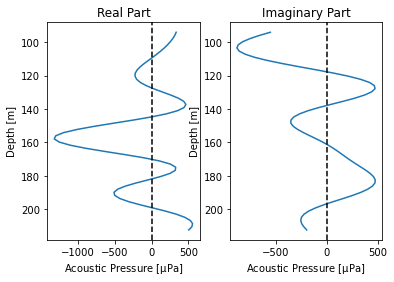

In [4]:
p_rec = run_kraken(fixedparams)

# Normalize pressure field
p_rec_norm = normalize_pressure(p_rec, log=True)

# Calculate covariance matrix
K = p_rec @ p_rec.conj().T

fig = plt.figure(figsize=(6, 4))

plt.subplot(1, 2, 1)
plt.plot(np.real(p_rec)*1e6, fixedparams["rec_z"])
plt.gca().invert_yaxis()
plt.axvline(0, c="k", linestyle="--")
plt.xlabel(r"Acoustic Pressure [$\mathrm{\mu}$Pa]")
plt.ylabel("Depth [m]")
plt.title("Real Part")

plt.subplot(1, 2, 2)
plt.plot(np.imag(p_rec)*1e6, fixedparams["rec_z"])
plt.gca().invert_yaxis()
plt.axvline(0, c="k", linestyle="--")
plt.xlabel(r"Acoustic Pressure [$\mathrm{\mu}$Pa]")
plt.ylabel("Depth [m]")
plt.title("Imaginary Part")

# fig.savefig("../../Reports/Figures/swellex_rx_pressure.png", dpi=300, facecolor="white", bbox_inches="tight")

## 2&nbsp;&nbsp;Optimization

In this section, we will attempt to localize the acoustic source and to estimate certain geoacoustic parameters which may be unknown.  Various methods are presented here, including grid search (matched field processing, or MFP), Bayesian optimization using a Gaussian process surrogate model (BOGP), and others.  A simple 2-D case is presented as a tutorial to demonstrate the BOGP method.

### 2.1&nbsp;&nbsp;Define search space

The first step is to define the parameter search space.  The source localization and geoacoustic parameters are split into two dictionaries: one for those parameters which are known and therefore fixed; and a second for those parameters which we seek to estimate.  These searchable parameters as ranges which will be sampled in the course of the various methods presented.

In the case of 2-D localization, the only search parameters are the source range and depth.

In [6]:
# ======================================================================
# ========================== FIXED PARAMETERS ==========================
# ======================================================================

# ---------------------- Miscellaneous Parameters ----------------------
fixedparams = dict()
fixedparams["title"] = "SWELLEX96"
fixedparams["tmpdir"] = "tmp"
fixedparams["model"] = "KRAKENC"

# --------------------------- Top Parameters ---------------------------
# None to configure.

# -------------------------- Layer Parameters --------------------------
fixedparams["layerdata"] = [
    {
        "z": z_data,
        "c_p": c_data,
        "rho": 1
    },
    {
        "z": [217, 240],
        "c_p": [1572.37, 1593.02],
        "rho": 1.8,
        "a_p": 0.3
    },
    {
        "z": [240, 1040],
        "c_p": [1881, 3245.8],
        "rho": 2.1,
        "a_p": 0.09
    }
]

# ------------------------- Bottom Parameters --------------------------
# Note: By default, bottom depth is pulled from layer data
fixedparams["bot_opt"] = "A"
fixedparams["bot_c_p"] = 5200.
fixedparams["bot_rho"] = 2.7
fixedparams["bot_a_p"] = 0.03

# ------------------------- Source Parameters --------------------------
fixedparams["src_z"] = depth_true

# ------------------------ Receiver Parameters ------------------------
fixedparams["rec_z"] = np.linspace(94.125, 212.25, 64)
# fixedparams["rec_r"] = range_true


# ------------------------ Freq/Mode Parameters ------------------------
fixedparams["freq"] = freq
fixedparams["clow"] = 0
fixedparams["chigh"] = 1600


# ======================================================================
# ============================ SEARCH SPACE ============================
# ======================================================================
parameters = [
    {
        "name": "rec_r",
        "type": "range",
        "bounds": [3.0, 6.0],
        "value_type": "float"
    },
    # {
    #     "name": "src_z",
    #     "type": "range",
    #     "bounds": [10., 100.],
    #     "value_type": "float"
    # }
]

### 2.2&nbsp;&nbsp;Matched Field Processing

In [6]:
dr = 5 / 1e3
rvec = np.arange(3., 6. + dr, dr)
zvec = np.arange(1., 211., 1)

pbar = tqdm(
    zvec,
    bar_format='{l_bar}{bar:20}{r_bar}{bar:-20b}',
    desc="MFP",
    leave=True,
    position=0,
    unit=" step"
)

p_rep = np.zeros((len(zvec), len(rvec), len(fixedparams["rec_z"])))
B_bart = np.zeros((len(zvec), len(rvec)))
# B_mvdr = np.zeros((len(zvec), len(rvec)))
for zz, z in enumerate(pbar):
    p_rep = run_kraken(fixedparams | {"src_z": z, "rec_r": rvec})    
    for rr, r in enumerate(rvec):
        B_bart[zz, rr] = ambiguity_function(K, p_rep[:, rr], atype="bartlett").item()
        # B_mvdr[zz, rr] = ambiguity_function(K, p_rep[:, rr], atype="MVDR").item()

MFP: 100%|████████████████████| 210/210 [00:10<00:00, 20.69 step/s]


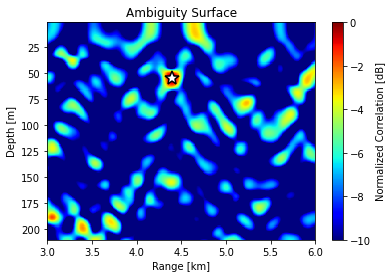

In [7]:
Bn = B_bart / np.max(B_bart)
logBn = 10 * np.log10(Bn)
src_z_ind, src_r_ind = np.unravel_index(np.argmax(logBn), (len(zvec), len(rvec)))

fig = plt.figure(figsize=(6, 4))
plt.imshow(
    logBn,
    aspect="auto",
    extent=[min(rvec), max(rvec), min(zvec), max(zvec)],
    origin="lower",
    vmin=-10, vmax=0, interpolation="none",
    cmap="jet"
)
plt.plot(rvec[src_r_ind], zvec[src_z_ind], 'w*', markersize=15, markeredgewidth=1.5, markeredgecolor="k")
plt.gca().invert_yaxis()
plt.xlabel("Range [km]")
plt.ylabel("Depth [m]")
plt.title("Ambiguity Surface")
plt.colorbar(label="Normalized Correlation [dB]")
plt.show()

# fig.savefig("../../Reports/Figures/MFP_SWELLEX.png", dpi=150, facecolor="white", bbox_inches="tight")
# fig.savefig("../../Reports/Figures/MFP_SWELLEX_nolocation.png", dpi=150, facecolor="white", bbox_inches="tight")

# Bn = B_mvdr / np.max(B_mvdr)
# logBn = 10 * np.log10(Bn)
# src_z_ind, src_r_ind = np.unravel_index(np.argmax(logBn), (len(zvec), len(rvec)))
# plt.imshow(
#     logBn,
#     aspect="auto",
#     extent=[min(rvec), max(rvec), min(zvec), max(zvec)],
#     origin="lower",
#     vmin=-200, vmax=0, interpolation="none")
# plt.plot(rvec[src_r_ind], zvec[src_z_ind], 'r*')
# plt.gca().invert_yaxis()
# plt.title("MVDR")
# plt.colorbar()
# plt.show()
# print(src_z_ind, src_r_ind)

Text(0.5, 1.0, 'Ambiguity Surface at $z=54.0$ m')

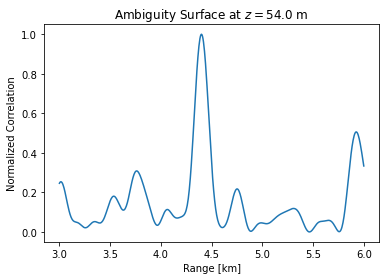

In [8]:
fig = plt.figure(figsize=(6, 4))
plt.plot(rvec, Bn[src_z_ind])
plt.xlabel("Range [km]")
plt.ylabel("Normalized Correlation")
plt.title(fr"Ambiguity Surface at $z={zvec[src_z_ind]}$ m")
# fig.savefig("../../Reports/Figures/1D_amb_surf.png", dpi=300, facecolor="white", bbox_inches="tight")

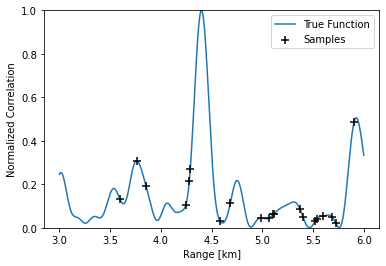

In [9]:
fig = plt.figure(figsize=(6, 4))
plt.plot(rvec, Bn[src_z_ind], label="True Function", zorder=1)
np.random.seed(3)
idx = np.random.randint(0, len(rvec), 20)
plt.scatter(rvec[idx], Bn[src_z_ind, idx], c="k", s=50, marker="+", label="Samples", zorder=2)
plt.ylim(0, 1)
plt.xlabel("Range [km]")
plt.ylabel("Normalized Correlation")
plt.legend()
# fig.savefig("../../Reports/Figures/1D_amb_surf_rand.png", dpi=300, facecolor="white", bbox_inches="tight")

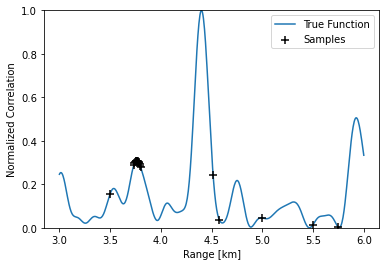

In [10]:
fig = plt.figure(figsize=(6, 4))
plt.plot(rvec, Bn[src_z_ind], label="True Function", zorder=1)
idx1 = np.arange(-7, 7) + 154
idx2 = np.array([100, 303, 315, 400, 500, 550])

idx = np.concatenate((idx1, idx2))
plt.scatter(rvec[idx], Bn[src_z_ind, idx], c="k", s=50, marker="+", label="Samples", zorder=2)
plt.ylim(0, 1)
plt.xlabel("Range [km]")
plt.ylabel("Normalized Correlation")
plt.legend()
# fig.savefig("../../Reports/Figures/1D_amb_surf_seqdemo.png", dpi=300, facecolor="white", bbox_inches="tight")

Text(0.5, 1.0, 'Functions drawn at random')

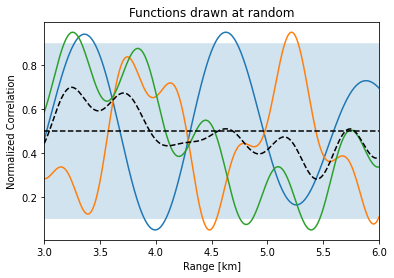

In [11]:
from numpy.random import randint
from sklearn.preprocessing import MinMaxScaler

fig = plt.figure(figsize=(6, 4))
np.random.seed(2009)
fsum = 0
for i in range(3):
    f = randint(1,100)*np.sin(randint(0,100) * rvec / rvec.max()) + randint(1,100)*np.cos(randint(0,100) * rvec / rvec.max())
    f = MinMaxScaler(feature_range=(0.05, 0.95)).fit_transform(f.reshape(-1, 1)).reshape(-1)
    plt.plot(rvec, f)
    fsum += f


plt.plot(rvec, fsum/3, "k--")
plt.axhline(0.5, c="k", linestyle="--")
plt.fill_between(rvec, 0.1 * np.ones_like(rvec), 0.9 * np.ones_like(rvec), alpha=0.2)
plt.xlim(rvec.min(), rvec.max())
# plt.ylim(0, 1)
plt.xlabel("Range [km]")
plt.ylabel("Normalized Correlation")
plt.title(fr"Functions drawn at random")
# fig.savefig("../../Reports/Figures/1D_rand_draws.png", dpi=300, facecolor="white", bbox_inches="tight")



In [ ]:
import scipy.stats as stats

np.random.seed(2018)
x = np.arange(1, 101, 1)
print(x.min())
mu = randint(1, 100)*np.sin(randint(0, 100) * x / x.max()) + randint(1, 100)*np.cos(randint(0, 100) * x / x.max())
mu = MinMaxScaler(feature_range=(-1, 1)).fit_transform(mu.reshape(-1, 1)).reshape(-1)

sigma = (5 * np.sin(2 * np.pi * x / x.max()) + 10 * x / x.max()) / 5
variance = np.sqrt(sigma)


fig = plt.figure(figsize=(4, 3), dpi=300)
plt.plot(mu, "k--", label="$\mu$")
plt.plot(mu - 2*sigma, "k", label="$\mu \pm 2\sigma$")
plt.plot(mu + 2*sigma, "k", label=None)
plt.fill_between(x, mu - 2*sigma, mu + 2*sigma, alpha=0.2, label=None)
plt.xlim(x.min(), x.max())
xi = [22, 55, 75]
[plt.axvline(i, c="k", linestyle=":") for i in xi]
plt.ylim(-4, 4)
plt.xticks(xi, [f"$x_{i+1}$" for i in range(len(xi))])
plt.xlabel("$\mathbf{x}=[x_1, x_2, \dots, x_n]$")
plt.ylabel("$f(\mathbf{x})$", rotation=0)
plt.tight_layout()
plt.legend(loc="upper right", framealpha=0.95)
plt.show()


fig = plt.figure(figsize=(9, 2), dpi=300)

for i, xi in enumerate(xi):
    m = mu[xi]
    s = sigma[xi]
    x = np.linspace(m - 3*s, m + 3*s, 101)
    f = stats.norm.pdf(x, m, s)
    plt.subplot(1, 3, i+1)
    plt.fill_between(x, 0, f, alpha=0.2, label=None)
    plt.plot([m, m], [0, f.max()], "k--", label="$\mu$")
    plt.plot([m + 2*s, m + 2*s], [0, stats.norm.pdf(m + 2*s, m, s)], "k", label="$\mu \pm 2\sigma$")
    plt.plot([m - 2*s, m - 2*s], [0, stats.norm.pdf(m - 2*s, m, s)], "k", label=None)


    plt.xlim(-4, 4)
    plt.ylim(0, 1)
    plt.xlabel(f"$x_{i+1}$")
    plt.ylabel(f"$f(x_{i+1})$", rotation=0, ha="right")
    if i == 0:
        plt.legend(loc="upper left", framealpha=0.95)

plt.tight_layout()

### Perform Bayesian optimization w/ Gaussian process

In [253]:
try:
    print(ax_client)
    del ax_client
    print("Deleted old instance of ax_client.")
except:
    pass

from copy import deepcopy
import warnings

from ax.core.arm import Arm
from ax.core.observation import ObservationFeatures
from ax.exceptions.generation_strategy import GenerationStrategyRepeatedPoints
from ax.models.torch.botorch_modular.surrogate import Surrogate
from botorch.models.gp_regression import SingleTaskGP
from botorch.acquisition import (
    ExpectedImprovement,
    ProbabilityOfImprovement,
    UpperConfidenceBound
)
from botorch.acquisition.monte_carlo import (
    qExpectedImprovement,
    qNoisyExpectedImprovement,
    qUpperConfidenceBound,
    qProbabilityOfImprovement,
)
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from gpytorch.utils.warnings import NumericalWarning
from matplotlib.gridspec import GridSpec


def evaluate(parameters):
    p_rep = run_kraken(parameters)
    objective_raw = ambiguity_function(K, p_rep, atype="bartlett").item()
    return {"bartlett": (objective_raw, 0.0)}


def plot_model(model):
    fig = plt.figure(figsize=(6, 4))
    plot_config = plot_slice(model, "rec_r", "bartlett").data["data"]

    x = plot_config[2]["x"]
    y = plot_config[2]["y"]
    # Error
    plt.fill_between(plot_config[0]["x"], plot_config[0]["y"], alpha=0.2, label="$\mu\pm 2\sigma$")
    # Mean
    plt.plot(plot_config[1]["x"], plot_config[1]["y"], label="$\mu$")
    # Evaluations
    plt.scatter(x, y, c="k", label="Samples")
    # Truth
    plt.plot(rvec, B_bart[src_z_ind], "r--", label="True Obj")

    plt.xlim(rvec.min(), rvec.max())
    plt.xlabel("Range [km]")
    plt.ylabel("Bartle Correlation")
    plt.title(fr"GP-approximated Ambiguity Surface")
    plt.legend(loc="upper right")
    return fig


warnings.filterwarnings("ignore", category=NumericalWarning)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

N_WARMUP = 10
NITER = 50

rvec_ = np.linspace(rvec.min(), rvec.max(), 5001)
observation_features = [ObservationFeatures.from_arm(Arm(parameters={"rec_r": v})) for v in rvec_]

acq_list = [
    {
        "name": "alpha_nei",
        "func": qNoisyExpectedImprovement,
        "opts": {"num_restarts": 50, "raw_samples": 512, "q": 16}
    },
    {
        "name": "alpha_ei",
        "func": qExpectedImprovement,
        "opts": {"num_restarts": 50, "raw_samples": 512, "q": 16}
    },
    {
        "name": "alpha_pi",
        "func": qProbabilityOfImprovement,
        "opts": {"num_restarts": 50, "raw_samples": 512, "q": 16}
    },
    # {
    #     "name": "alpha_ucb",
    #     "func": qUpperConfidenceBound,
    #     "opts": {"num_restarts": 50, "raw_samples": 512, "q": 16, "beta": 2}
    # }
]

ax_client_list = []

for acq_func in acq_list:
# for acq_func in [acq_list[0]]:

    gs = GenerationStrategy(
        steps=[
            GenerationStep(
                model=Models.SOBOL,
                num_trials=N_WARMUP,  # How many trials should be produced from this generation step
                min_trials_observed=3,  # How many trials need to be completed to move to next model
                max_parallelism=5,  # Max parallelism for this step
                model_kwargs={"seed": 2000},  # Any kwargs you want passed into the model
                model_gen_kwargs={},  # Any kwargs you want passed to `modelbridge.gen`
            ),
            GenerationStep(
                model=Models.BOTORCH_MODULAR,
                num_trials=NITER - N_WARMUP,
                max_parallelism=None,
                model_kwargs={
                    "torch_device": device,
                    "surrogate": Surrogate(
                        botorch_model_class=SingleTaskGP,
                        mll_class=ExactMarginalLogLikelihood,
                    ),
                    "botorch_acqf_class": acq_func["func"],
                    "acquisition_options": acq_func["opts"]
                },
                should_deduplicate=True,
            )
        ]
    )

    ax_client = AxClient(generation_strategy=gs, verbose_logging=False)
    ax_client.create_experiment(
        name=acq_func["name"],
        parameters=parameters,
        objective_name="bartlett"
    )


    pbar = tqdm(
        range(NITER),
        bar_format="{l_bar}{bar:20}{r_bar}{bar:-20b}",
        desc="BO",
        leave=True,
        position=0,
        unit="eval",
    )

    counter = 0
    for i in pbar:
        # try:
        searchparams, trial_index = ax_client.get_next_trial()
        # except GenerationStrategyRepeatedPoints:

        

        if i > N_WARMUP - 1:
            ax_client_copy = deepcopy(ax_client)
            model = ax_client_copy.generation_strategy.model

            counter += 1

            fig = plt.figure(figsize=(6, 4))
            plot_config = plot_slice(model, "rec_r", "bartlett").data["data"]
            x = plot_config[2]["x"]
            y = plot_config[2]["y"]
            # Error
            gspec = GridSpec(2, 1, hspace=0.05, height_ratios=[3, 1])

            ax0 = fig.add_subplot(gspec[0])

            ax0.fill_between(plot_config[0]["x"], plot_config[0]["y"], alpha=0.2, label="$\mu\pm 2\sigma$")
            # Mean
            ax0.plot(plot_config[1]["x"], plot_config[1]["y"], label="$\mu$")
            # Evaluations
            ax0.scatter(x, y, c="k", label="Samples")
            # Truth
            ax0.plot(rvec, B_bart[src_z_ind], "r--", label="True Obj")
            
            ax0.set_xlim(rvec.min()-0.1, rvec.max()+0.1)
            ax0.set_ylim(-0.5e-5, 2.7e-5)
            ax0.set_xticks([])
            ax0.set_xticklabels([])
            ax0.spines["bottom"].set_visible(False)
            ax0.set_ylabel("Output Value")
            ax0.set_title(f"Sample {counter}")
            
            acqf_values = np.array(model.evaluate_acquisition_function(
                observation_features=observation_features,
                search_space=ax_client.generation_strategy.model.model_space,
                optimization_config=model._optimization_config
            ))
            acqf_values /= acqf_values.max()

            

            # x_next = rvec[np.argmax(acqf_values)]
            x_next = searchparams["rec_r"]


            ax1 = fig.add_subplot(gspec[1])
            ax1.plot(rvec_, acqf_values, "k", label=r"$\alpha$")

            ax1.set_xlabel("Range [km]")
            ax1.set_ylabel(r"$\alpha / \alpha_{max}$")
            ax1.set_xlim(rvec.min()-0.1, rvec.max()+0.1)
            ax1.spines["top"].set_visible(False)

            ax1.axvline(x_next, c="k", ls="--")
            ax0.axvline(x_next, c="k", ls="--")

            fig.legend(bbox_to_anchor=(1.1, 0.9))
            fig.savefig(f"../../Reports/Figures/animations/{acq_func['name']}/{counter:02d}.png", dpi=150, facecolor="white", bbox_inches="tight")
            plt.close()


        ax_client.complete_trial(
            trial_index=trial_index, raw_data=evaluate(fixedparams | searchparams)
        )


        best_trial, _, (best_obj, _) = ax_client.get_best_trial(use_model_predictions=False)
        pbar.set_postfix(
            {"Best Trial": best_trial}
            | {k: v for k, v in searchparams.items()}
            | {"obj": best_obj["bartlett"]}
        )

    best_parameters, (means, covariances) = ax_client.get_best_parameters()
    print(best_parameters)
    ax_client_list.append(ax_client)
    # del ax_client, ax_client_copy

[INFO 05-26 05:35:42] ax.service.utils.instantiation: Created search space: SearchSpace(parameters=[RangeParameter(name='rec_r', parameter_type=FLOAT, range=[3.0, 6.0])], parameter_constraints=[]).


Deleted old instance of ax_client.


BO: 100%|████████████████████| 50/50 [01:12<00:00,  1.45s/eval, Best Trial=46, rec_r=4.4, obj=2.6e-5] 
[INFO 05-26 05:36:55] ax.service.utils.instantiation: Created search space: SearchSpace(parameters=[RangeParameter(name='rec_r', parameter_type=FLOAT, range=[3.0, 6.0])], parameter_constraints=[]).


{'rec_r': 4.399974235283269}


BO:  20%|████                | 10/50 [00:00<00:03, 11.31eval/s, Best Trial=3, rec_r=5.31, obj=2.2e-5]/var/folders/bv/_l6pjvb135z9qm2kwx7n6fhw0000gn/T/ipykernel_28611/3032622227.py:188: RuntimeWarning:

invalid value encountered in true_divide

BO:  20%|████                | 10/50 [00:01<00:03, 11.31eval/s, Best Trial=3, rec_r=4.58, obj=2.2e-5]/var/folders/bv/_l6pjvb135z9qm2kwx7n6fhw0000gn/T/ipykernel_28611/3032622227.py:188: RuntimeWarning:

invalid value encountered in true_divide

BO:  26%|█████▏              | 13/50 [00:03<00:15,  2.38eval/s, Best Trial=3, rec_r=4.23, obj=2.2e-5]/var/folders/bv/_l6pjvb135z9qm2kwx7n6fhw0000gn/T/ipykernel_28611/3032622227.py:188: RuntimeWarning:

invalid value encountered in true_divide

BO:  28%|█████▌              | 14/50 [00:03<00:16,  2.16eval/s, Best Trial=3, rec_r=5.41, obj=2.2e-5]/var/folders/bv/_l6pjvb135z9qm2kwx7n6fhw0000gn/T/ipykernel_28611/3032622227.py:188: RuntimeWarning:

invalid value encountered in true_divide

BO:  30%|██████         

{'rec_r': 4.39996035780138}


BO:  20%|████                | 10/50 [00:01<00:03, 12.05eval/s, Best Trial=3, rec_r=4.3, obj=2.2e-5] /var/folders/bv/_l6pjvb135z9qm2kwx7n6fhw0000gn/T/ipykernel_28611/3032622227.py:188: RuntimeWarning:

invalid value encountered in true_divide

BO:  24%|████▊               | 12/50 [00:01<00:09,  3.96eval/s, Best Trial=3, rec_r=4.3, obj=2.2e-5]/var/folders/bv/_l6pjvb135z9qm2kwx7n6fhw0000gn/T/ipykernel_28611/3032622227.py:188: RuntimeWarning:

invalid value encountered in true_divide

BO:  26%|█████▏              | 13/50 [00:02<00:14,  2.58eval/s, Best Trial=3, rec_r=3.62, obj=2.2e-5]/var/folders/bv/_l6pjvb135z9qm2kwx7n6fhw0000gn/T/ipykernel_28611/3032622227.py:188: RuntimeWarning:

invalid value encountered in true_divide

BO:  28%|█████▌              | 14/50 [00:03<00:15,  2.26eval/s, Best Trial=3, rec_r=4.26, obj=2.2e-5]/var/folders/bv/_l6pjvb135z9qm2kwx7n6fhw0000gn/T/ipykernel_28611/3032622227.py:188: RuntimeWarning:

invalid value encountered in true_divide

BO:  30%|██████          

{'rec_r': 4.400368296913949}


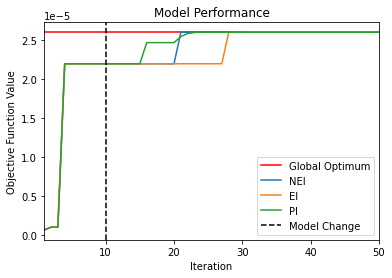

In [255]:
fig = plt.figure(figsize=(6,4))
plt.axhline(B_bart.max(), c="r", label="Global Optimum")


names = ["NEI", "EI", "PI"]

for i, ax_client in enumerate(ax_client_list):

    data = ax_client.get_optimization_trace().data["data"]
    x = data[0]["x"]
    y = data[0]["y"]
    xv = data[3]["x"]
    yv = data[3]["y"]

    plt.plot(x, y, label=names[i])

plt.axvline(xv[0], c="k", linestyle="--", label="Model Change")
plt.xlim(min(x), max(x))
plt.xlabel("Iteration")
plt.ylabel("Objective Function Value")
plt.legend()
plt.title("Model Performance")
plt.savefig("../../Reports/Figures/perf_trace_1D.png", dpi=300, facecolor="white", bbox_inches="tight")

In [259]:
# ======================================================================
# ========================== FIXED PARAMETERS ==========================
# ======================================================================

# ---------------------- Miscellaneous Parameters ----------------------
fixedparams = dict()
fixedparams["title"] = "SWELLEX96"
fixedparams["tmpdir"] = "tmp"
fixedparams["model"] = "KRAKENC"

# --------------------------- Top Parameters ---------------------------
# None to configure.

# -------------------------- Layer Parameters --------------------------
fixedparams["layerdata"] = [
    {
        "z": z_data,
        "c_p": c_data,
        "rho": 1
    },
    {
        "z": [217, 240],
        "c_p": [1572.37, 1593.02],
        "rho": 1.8,
        "a_p": 0.3
    },
    {
        "z": [240, 1040],
        "c_p": [1881, 3245.8],
        "rho": 2.1,
        "a_p": 0.09
    }
]

# ------------------------- Bottom Parameters --------------------------
# Note: By default, bottom depth is pulled from layer data
fixedparams["bot_opt"] = "A"
fixedparams["bot_c_p"] = 5200.
fixedparams["bot_rho"] = 2.7
fixedparams["bot_a_p"] = 0.03

# ------------------------- Source Parameters --------------------------
fixedparams["src_z"] = depth_true

# ------------------------ Receiver Parameters ------------------------
fixedparams["rec_z"] = np.linspace(94.125, 212.25, 64)
# fixedparams["rec_r"] = range_true


# ------------------------ Freq/Mode Parameters ------------------------
fixedparams["freq"] = freq
fixedparams["clow"] = 0
fixedparams["chigh"] = 1600


# ======================================================================
# ============================ SEARCH SPACE ============================
# ======================================================================
parameters = [
    {
        "name": "rec_r",
        "type": "range",
        "bounds": [3., 6.],
        "value_type": "float"
    },
    {
        "name": "src_z",
        "type": "range",
        "bounds": [10., 100.],
        "value_type": "float"
    }
]

In [310]:
try:
    print(ax_client)
    del ax_client
    print("Deleted old instance of ax_client.")
except:
    pass

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

N_WARMUP = 10
NITER = 50

gs = GenerationStrategy(
    steps=[
        # 1. Initialization step (does not require pre-existing data and is well-suited for
        # initial sampling of the search space)
        GenerationStep(
            model=Models.SOBOL,
            num_trials=N_WARMUP,  # How many trials should be produced from this generation step
            min_trials_observed=3,  # How many trials need to be completed to move to next model
            max_parallelism=5,  # Max parallelism for this step
            model_kwargs={"seed": 2000},  # Any kwargs you want passed into the model
            model_gen_kwargs={},  # Any kwargs you want passed to `modelbridge.gen`
        ),
        # 2. Bayesian optimization step (requires data obtained from previous phase and learns
        # from all data available at the time of each new candidate generation call)
        GenerationStep(
            model=Models.GPEI,
            num_trials=-1,  # No limitation on how many trials should be produced from this step
            max_parallelism=1,  # Parallelism limit for this step, often lower than for Sobol
            # More on parallelism vs. required samples in BayesOpt:
            # https://ax.dev/docs/bayesopt.html#tradeoff-between-parallelism-and-total-number-of-trials
            model_kwargs={"torch_device": device},
        ),
        # GenerationStep(
        #     model=Models.BO_MIXED,
        #     num_trials=-1,  # No limitation on how many trials should be produced from this step
        #     max_parallelism=1,  # Parallelism limit for this step, often lower than for Sobol
        #     # More on parallelism vs. required samples in BayesOpt:
        #     # https://ax.dev/docs/bayesopt.html#tradeoff-between-parallelism-and-total-number-of-trials
        #     model_kwargs={"torch_device": device}
        # ),
    ]
)

ax_client = AxClient(generation_strategy=gs, verbose_logging=False)
ax_client.create_experiment(
    name="test_kraken",
    parameters=parameters,
    objective_name="bartlett",
    # minimize=True,  # Optional, defaults to False.
    # parameter_constraints=["x1 + x2 <= 2.0"],  # Optional.
    # outcome_constraints=["bartlett_const >= 0.0"],  # Optional.
)


def evaluate(parameters):
    p_rep = run_kraken(parameters)
    objective_raw = ambiguity_function(K, p_rep, atype="bartlett").item()
    return {"bartlett": (objective_raw, 0.0)}


def plot_2D(ax_client, counter):
    fig = plt.figure(figsize=(12, 4))
    gspec = GridSpec(1, 2)

    ax0 = fig.add_subplot(gspec[0])
    x = np.array(ax_client.get_contour_plot().data["data"][0]["x"])
    y = np.array(ax_client.get_contour_plot().data["data"][0]["y"])
    Z = np.array(ax_client.get_contour_plot().data["data"][0]["z"])
    X, Y = np.meshgrid(x, y)
    plt.contourf(X, Y, Z, 20, cmap="jet")
    plt.colorbar()
    xdata = ax_client.get_trials_data_frame()["rec_r"].to_numpy()
    ydata = ax_client.get_trials_data_frame()["src_z"].to_numpy()
    plt.scatter(xdata[:-1], ydata[:-1], c="k")
    plt.scatter(xdata[-1], ydata[-1], c="w")
    plt.axvline(xdata[-1], c="w", ls="--")
    plt.axhline(ydata[-1], c="w", ls="--")

    plt.plot(range_true, depth_true, 'w*', markersize=15, markeredgewidth=1.5, markeredgecolor="k")
    plt.gca().invert_yaxis()
    
    plt.xlabel("Range [km]")
    plt.ylabel("Depth [m]")
    plt.title(f"Sample {counter}\nMean Surace")
    

    ax1 = fig.add_subplot(gspec[1])
    x = np.array(ax_client.get_contour_plot().data["data"][1]["x"])
    y = np.array(ax_client.get_contour_plot().data["data"][1]["y"])
    Z = np.array(ax_client.get_contour_plot().data["data"][1]["z"])
    X, Y = np.meshgrid(x, y)
    plt.contourf(X, Y, Z, 20, cmap="jet")
    plt.colorbar()
    plt.scatter(xdata[:-1], ydata[:-1], c="k")
    plt.scatter(xdata[-1], ydata[-1], c="w")
    plt.axvline(xdata[-1], c="w", ls="--")
    plt.axhline(ydata[-1], c="w", ls="--")
    plt.plot(range_true, depth_true, 'w*', markersize=15, markeredgewidth=1.5, markeredgecolor="k")
    plt.gca().invert_yaxis()
    
    plt.xlabel("Range [km]")
    plt.ylabel("Depth [m]")
    plt.title("SE Surace")
    plt.savefig(f"../../Reports/Figures/animations/2D_ei/{counter:02d}.png", facecolor="white", bbox_inches="tight", dpi=150)
    
    plt.close()


pbar = tqdm(
    range(NITER),
    bar_format="{l_bar}{bar:20}{r_bar}{bar:-20b}",
    desc="BO",
    leave=True,
    position=0,
    unit="eval",
)

counter = 0
for i in pbar:
    searchparams, trial_index = ax_client.get_next_trial()
    ax_client.complete_trial(
        trial_index=trial_index, raw_data=evaluate(fixedparams | searchparams)
    )

    if i > N_WARMUP - 1:
        counter += 1
        plot_2D(ax_client, counter)


    best_trial, _, (best_obj, _) = ax_client.get_best_trial(use_model_predictions=False)
    pbar.set_postfix(
        {"Best Trial": best_trial}
        | {k: v for k, v in searchparams.items()}
        | {"obj": best_obj["bartlett"]}
    )


best_parameters, (means, covariances) = ax_client.get_best_parameters()
print(best_parameters)
print(range_true, depth_true)
# print(means)

[INFO 05-26 06:40:59] ax.service.utils.instantiation: Created search space: SearchSpace(parameters=[RangeParameter(name='rec_r', parameter_type=FLOAT, range=[3.0, 6.0]), RangeParameter(name='src_z', parameter_type=FLOAT, range=[10.0, 100.0])], parameter_constraints=[]).


Deleted old instance of ax_client.


BO: 100%|████████████████████| 50/50 [01:54<00:00,  2.29s/eval, Best Trial=33, rec_r=3.63, src_z=51.6, obj=2.6e-5] 


{'rec_r': 4.398862661240903, 'src_z': 54.16675788924769}
4.4 54


[INFO 05-26 06:09:56] ax.modelbridge.generation_strategy: Note that parameter values in dataframe are rounded to 2 decimal points; the values in the dataframe are thus not the exact ones suggested by Ax in trials.


array([60.20843148, 48.67553311, 92.60812775, 13.57521798, 83.00109133,
       26.6879217 , 70.30949577, 36.49633603, 98.04037021, 19.40297379,
       41.53549943, 21.67229128, 37.48401116, 43.39716936, 44.33978796,
       46.96245   , 48.9666163 , 48.07020806])

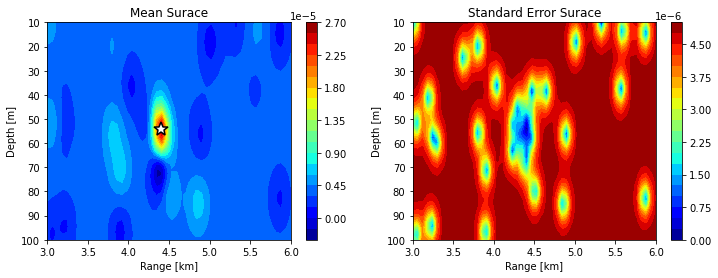

In [271]:
import plotly.graph_objects as go

def plot_2D(ax_client):
    fig = plt.figure(figsize=(12, 4))
    gspec = GridSpec(1, 2)

    ax0 = fig.add_subplot(gspec[0])
    x = np.array(ax_client.get_contour_plot().data["data"][0]["x"])
    y = np.array(ax_client.get_contour_plot().data["data"][0]["y"])
    Z = np.array(ax_client.get_contour_plot().data["data"][0]["z"])
    X, Y = np.meshgrid(x, y)
    plt.contourf(X, Y, Z, 20, cmap="jet")
    plt.plot(best_parameters["rec_r"], best_parameters["src_z"], 'w*', markersize=15, markeredgewidth=1.5, markeredgecolor="k")
    plt.gca().invert_yaxis()
    cbar = plt.colorbar()
    plt.xlabel("Range [km]")
    plt.ylabel("Depth [m]")
    plt.title("Mean Surace")
    # plt.savefig("../../Reports/Figures/GP_2D_Sim_Mean.png", facecolor="white", bbox_inches="tight", dpi=300)
    # plt.show()

    ax1 = fig.add_subplot(gspec[1])
    x = np.array(ax_client.get_contour_plot().data["data"][1]["x"])
    y = np.array(ax_client.get_contour_plot().data["data"][1]["y"])
    Z = np.array(ax_client.get_contour_plot().data["data"][1]["z"])
    X, Y = np.meshgrid(x, y)
    plt.contourf(X, Y, Z, 20, cmap="jet")
    plt.gca().invert_yaxis()
    cbar = plt.colorbar()
    plt.xlabel("Range [km]")
    plt.ylabel("Depth [m]")
    plt.title("Standard Error Surace")
    # plt.savefig("../../Reports/Figures/GP_2D_Sim_SE.png", facecolor="white", bbox_inches="tight", dpi=300)
    
    plt.show()

plot_2D(ax_client)

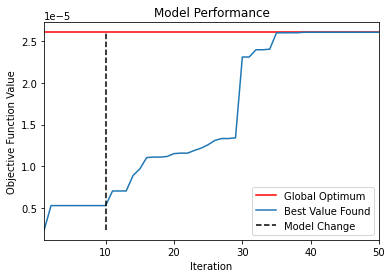

In [309]:
data = ax_client.get_optimization_trace().data["data"]
x = data[0]["x"]
y = data[0]["y"]
xv = data[3]["x"]
yv = data[3]["y"]

fig = plt.figure(figsize=(6,4))
plt.axhline(B_bart.max(), c="r", label="Global Optimum")
plt.plot(x, y, label="Best Value Found")
plt.plot(xv, yv, "k--", label="Model Change")
plt.xlim(min(x), max(x))
plt.xlabel("Iteration")
plt.ylabel("Objective Function Value")
plt.legend()
plt.title("Model Performance")
plt.savefig("../../Reports/Figures/perf_trace_2D.png", dpi=300, facecolor="white", bbox_inches="tight")

In [19]:
B_bart.max()

2.6048110592448504e-05

In [47]:
test = np.arange(3, 6, 0.5).reshape(1, -1)

array([[3. , 3.5, 4. , 4.5, 5. , 5.5]])

In [69]:
[Arm(parameters={"rec_r": v}) for v in np.arange(3, 6, 0.5)]

[Arm(parameters={'rec_r': 3.0}),
 Arm(parameters={'rec_r': 3.5}),
 Arm(parameters={'rec_r': 4.0}),
 Arm(parameters={'rec_r': 4.5}),
 Arm(parameters={'rec_r': 5.0}),
 Arm(parameters={'rec_r': 5.5})]

In [68]:
ax_client.experiment.arms_by_name.values()

dict_values([Arm(name='0_0', parameters={'rec_r': 4.8861894607543945}), Arm(name='1_0', parameters={'rec_r': 3.8336969213560224}), Arm(name='2_0', parameters={'rec_r': 3.2944608544930816}), Arm(name='3_0', parameters={'rec_r': 5.987575443461537}), Arm(name='4_0', parameters={'rec_r': 5.561629551462829}), Arm(name='5_0', parameters={'rec_r': 4.237398973018873}), Arm(name='6_0', parameters={'rec_r': 3.0}), Arm(name='7_0', parameters={'rec_r': 6.0}), Arm(name='8_0', parameters={'rec_r': 5.849454670440311}), Arm(name='9_0', parameters={'rec_r': 5.947946790792236})])

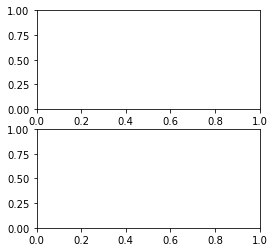

In [14]:
fig = plt.figure(figsize=(4, 4))

ax0 = plt.subplot(2, 1, 1)

ax1 = plt.subplot(2, 1, 2)


plt.show()